# Getting Started
Let's walk through an example application of Geometricus in machine learning using a dataset of
human MAP kinases, divided into three classes - JNK, Erk, and p38 kinases. This dataset was generated from the [Kinase-Ligand Interaction Fingerprints and Structures database (KLIFS)](https://klifs.vu-compmedchem.nl/index.php) (Raw table [here](../../example_data/MAPK_KLIFS.tsv)).

In [5]:
import pandas as pnd
from time import time

url = "https://raw.githubusercontent.com/TurtleTools/geometricus/master/example_data/MAPK_KLIFS.tsv"
mapk_df = pnd.read_csv(url, sep="\t")

mapk_pdb_id_to_class = {}
for pdb_id, chain, class_name in list(zip(mapk_df["PDB"], mapk_df["CHAIN"], mapk_df["CLASS"])):
    mapk_pdb_id_to_class[f"{pdb_id}_{chain}"] = class_name
len(mapk_pdb_id_to_class)

527

So now we have a list of PDBID_chain pairs, each associated with a class

In [6]:
X_names = list(mapk_pdb_id_to_class.keys())
class_mapping = {"JNK": 0, "Erk": 1, "p38": 2}
y = [class_mapping[mapk_pdb_id_to_class[k]] for k in X_names]

## Structural fragmentation

We consider two different ways of dividing a protein with $l$ residues into structural fragments, a $k$-mer-based approach and a radius-based approach. For each structural fragment, multiple rotation and translation-invariant moments can be calculated. While the $k$-mer based approach is effective in describing structural fragments that are sequential in nature, such as $\alpha$-helices and loops, the radius-based approach can capture long-range structural contacts as seen in $\beta$-sheets, as well as distinct interaction patterns in space, as found in enzyme active sites.

* KMER - each residue is taken as the center of a kmer of length `split_size`, ends are included but shorter
* RADIUS - overlapping spheres of radius `split_size`

Moment invariants can be calculated using the `from_structure_file` constructor function of the `geometricus.MultipleMomentInvariants` class - this also allows simply giving the PDB ID and chain as input. Generally more useful is the function `geometricus.get_invariants_for_structures` that does multithreaded moment calculation for list of input structure files or PDB IDs.

The `resolution` parameter describes how fine or coarse grained the resultant shape-mers are. This number is multiplied to each moment invariant value after which these values are rounded to the nearest integer.

In [ ]:
from geometricus import get_invariants_for_structures, Geometricus, SplitInfo, SplitType
import numpy as np

invariants, _ = get_invariants_for_structures(X_names, n_threads=4,
                                              split_infos=[SplitInfo(SplitType.KMER, 8)],
                                              moment_types=["O_3", "O_4", "O_5", "F"])
start_time = time()
kmer_shapemer_class = Geometricus.from_invariants(invariants, protein_keys=X_names, resolution=1.)
print(f"Generated kmer shapemers in {(time() - start_time):.2f} seconds")
invariants, _ = get_invariants_for_structures(X_names, n_threads=4,
                                              split_infos=[SplitInfo(SplitType.RADIUS, 5)],
                                              moment_types=["O_3", "O_4", "O_5", "F"])
radius_shapemer_class = Geometricus.from_invariants(invariants, protein_keys=X_names, resolution=1.)
print(f"Generated radius shapemers in {(time() - start_time):.2f} seconds")


Shapemers can also be generated using the trained `ShapemerLearn` model present in this repository. This uses four different fragmentation techniques: (RADIUS, 5), (RADIUS, 10), (KMER, 8), and (KMER, 16) and all MomentTypes, and has been trained to generate 1024 unique shape-mers.

The previous code can be modified to use the `ShapemerLearn` model as follows:

```python
from geometricus import get_invariants_for_structures, Geometricus, ShapemerLearn
invariants, errors = get_invariants_for_structures(X_names, n_threads=4)
model = ShapemerLearn.load()
shapemer_class = Geometricus.from_invariants(invariants, model=model, protein_keys=X_names)
```

We can simply count how many times each shapemer appears to get a representation for each protein

In [18]:
shapemer_count_matrix = np.vstack((kmer_shapemer_class.get_count_matrix(), radius_shapemer_class.get_count_matrix()))
shapemer_count_matrix.shape

(527, 495)

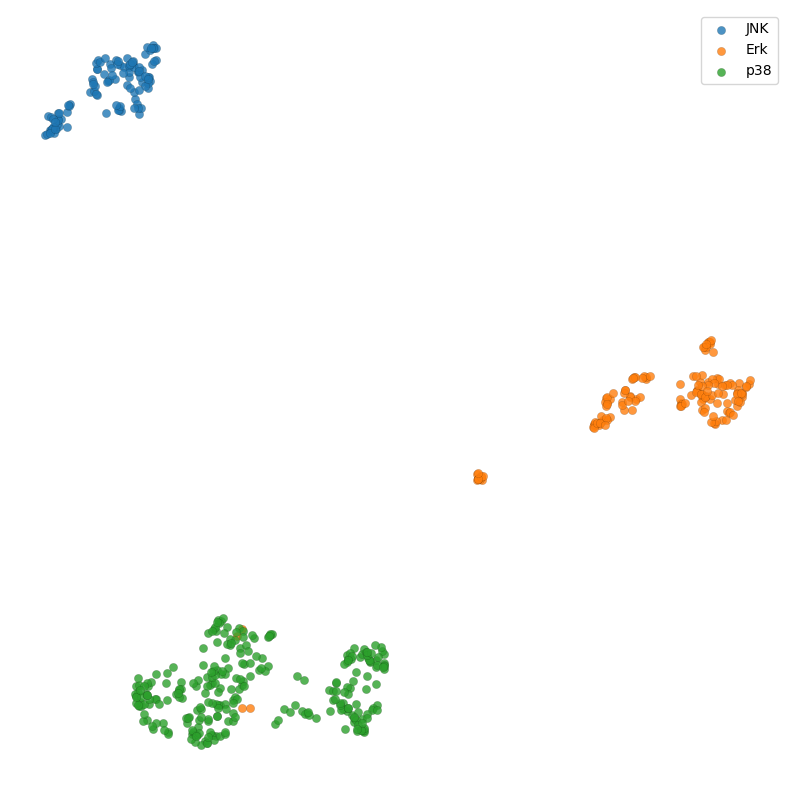

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import umap

reducer = umap.UMAP(metric="cosine", n_components=2)
reduced = reducer.fit_transform(shapemer_count_matrix)

class_names = ["JNK", "Erk", "p38"]
colors = ["red", "green", "blue"]
plt.figure(figsize=(10, 10))
for i in range(3):
    indices = np.where(np.array(y) == i)[0]
    plt.scatter(reduced[indices, 0],
                reduced[indices, 1],
                label=class_names[i], edgecolor="black", linewidth=0.1, alpha=0.8)
plt.axis("off")
plt.legend();

### Embedding for Supervised Learning
Supervised learning, be it classification or regression, requires some form of training and test set separation.

Below, the shapemers used for count matrix calculation are only those present in the training set.

In [22]:
from sklearn.model_selection import train_test_split

X_train_names, X_test_names, y_train, y_test = train_test_split(X_names, y, test_size=0.3)
_, train_shapemers = kmer_shapemer_class.map_protein_to_shapemer_indices(protein_keys=X_train_names)
X_train = kmer_shapemer_class.get_count_matrix(X_train_names, shapemer_keys=train_shapemers)
X_test = kmer_shapemer_class.get_count_matrix(X_test_names, shapemer_keys=train_shapemers)

For this simple problem, a decision tree classifier is more than enough to obtain good accuracy.

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0, 1, 2], target_names=class_names))

              precision    recall  f1-score   support

         JNK       0.84      0.90      0.87        30
         Erk       1.00      0.81      0.90        43
         p38       0.90      0.97      0.93        86

    accuracy                           0.91       159
   macro avg       0.92      0.89      0.90       159
weighted avg       0.92      0.91      0.91       159



## Finding predictive residues and structural fragments

Since each shape-mer can be mapped back to the residues it describes, it's easy to use Geometricus to determine predictive or functionally relevant residues and structural regions from a trained predictor (or from loadings generated from a method such as PCA). Such insights can be directly be applied to select candidate residues for mutational studies or used in directed evolution techniques to engineer proteins and enzymes with desired properties.

By inspecting the decision tree created above, it becomes clear that some shape-mers are present multiple times across a protein and the number of times differs across classes.

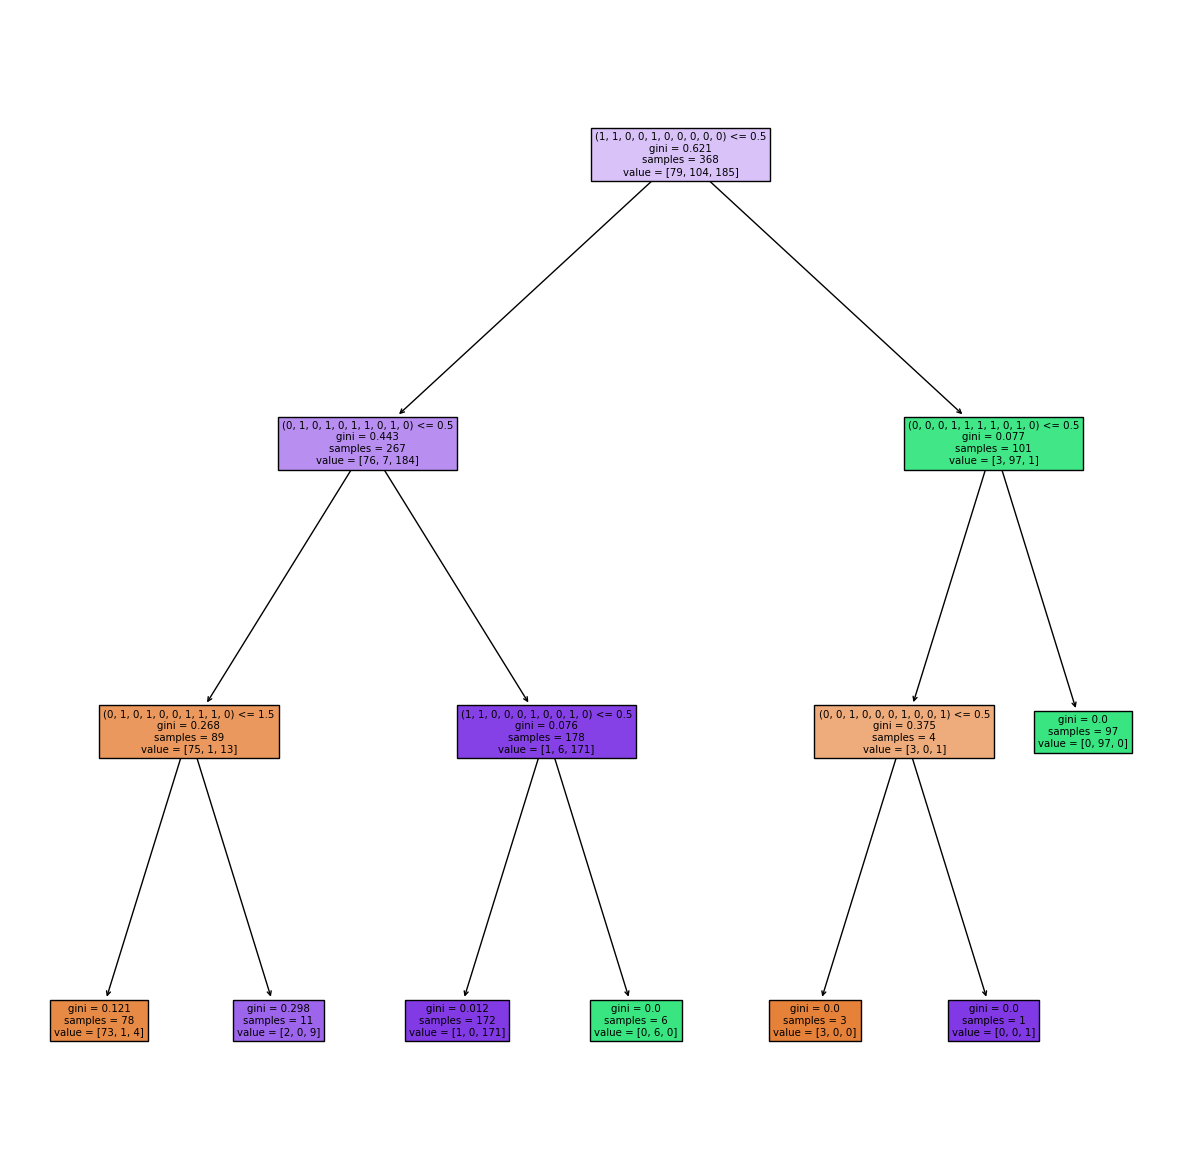

In [24]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(1, figsize=(15, 15))
plot_tree(clf, filled=True, ax=ax, feature_names=train_shapemers);

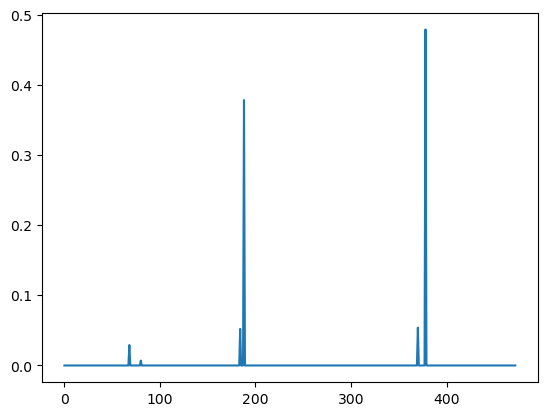

In [25]:
plt.plot(clf.feature_importances_)
predictive_feature_indices = np.argsort(clf.feature_importances_)[::-1][:6]

We can map back to the residues described by a shape-mer using the `map_shapemer_to_residues` function which returns a dictionary mapping each protein to the corresponding residue indices of the shape-mer within that protein, if it exists.

In [26]:
shapemer = train_shapemers[predictive_feature_indices[1]]
residue_indices = kmer_shapemer_class.map_shapemer_to_residues(shapemer)
print("Shape-mer:", shapemer, "Number of proteins with shape-mer:", len(residue_indices))
print()
print("Residue indices per protein (for 10 proteins):")
for i, key in enumerate(residue_indices):
    if i > 10:
        break
    print(key, residue_indices[key])

Shape-mer: (0, 1, 0, 1, 0, 1, 1, 0, 1, 0) Number of proteins with shape-mer: 307

Residue indices per protein (for 10 proteins):
4eh8_A {288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 284, 285, 286, 287}
4eh2_A {288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 285, 286, 287}
4eh7_A {288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 285, 286, 287}
4eh5_A {288, 289, 290, 291, 292, 293, 294, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287}
4dli_A {288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 282, 283, 284, 285, 286, 287}
4eh3_A {288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 287}
4eh6_A {288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 283, 284, 285, 286, 287}
4eh4_A {288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 285, 286, 287}
4eh9_A {288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 282, 283, 284, 285,

These residue indices can then be visualized on a protein structure using molecule visualization software such as PyMol. Comparing the same location in proteins which don't have this shape-mer can also be informative.